In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D, Trainer1D, Dataset1D

In [2]:
def sinu_frequency(x, freq):
    return np.sin(freq * np.pi * x)

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

x_values = np.linspace(0, 8, 128)

In [3]:
low_freq_range = np.arange(1,5,1)/5
high_freq_range = np.arange(1,5,1)

sampled_labels = []
for low_freq in low_freq_range:
    for high_freq in high_freq_range:
        sampled_labels.append([low_freq, high_freq])

# sampled labels

In [3]:
model = Unet1D(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels = 1
)

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 128,
    timesteps = 1000,
    objective = 'pred_noise'
)
dataset_name = '2_29_sine_dataset'
# training_seq = torch.rand(64, 32, 128) # features are normalized from 0 to 1
with open(f'./dataset/{dataset_name}/data.pkl', 'rb') as f:
    dataset = pickle.load(f)
# dataset = torch.tensor(data)
# dataset = Dataset1D(dataset_tensor)  # this is just an example, but you can formulate your own Dataset and pass it into the `Trainer1D` below

# loss = diffusion(dataset)
# loss.backward()

# Or using trainer

trainer = Trainer1D(
    diffusion,
    dataset = dataset,
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 10000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    num_samples = len(sampled_labels), # number of samples to generate for logging
    results_folder = './results/3_3_sine', # folder to save results
    amp = True,                       # turn on mixed precision
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/om2/user/qiyao/.conda/envs/env1/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 48 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

In [5]:
trainer.load(10)

accelerator = trainer.accelerator
device = accelerator.device
unzipped_sampled_labels = list(zip(*sampled_labels))
sampled_labels_device = [torch.tensor(lab, dtype=torch.float).to(
    device) for lab in unzipped_sampled_labels]

trainer.ema.ema_model.eval()

with torch.no_grad():
    milestone = trainer.step // trainer.save_and_sample_every
    batches = num_to_groups(trainer.num_samples, trainer.batch_size)
    all_samples_list = list(map(lambda n: trainer.ema.ema_model.sample(
        batch_size=n, labels=sampled_labels_device), batches))

all_samples = torch.cat(all_samples_list, dim=0)

loading from version 1.11.0


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
# Assuming `all_samples` is your tensor
if all_samples.is_cuda:
    # Move the tensor to CPU if it is on GPU
    all_samples = all_samples.cpu()

# Convert to NumPy array
samples_numpy = all_samples.numpy().squeeze(1)


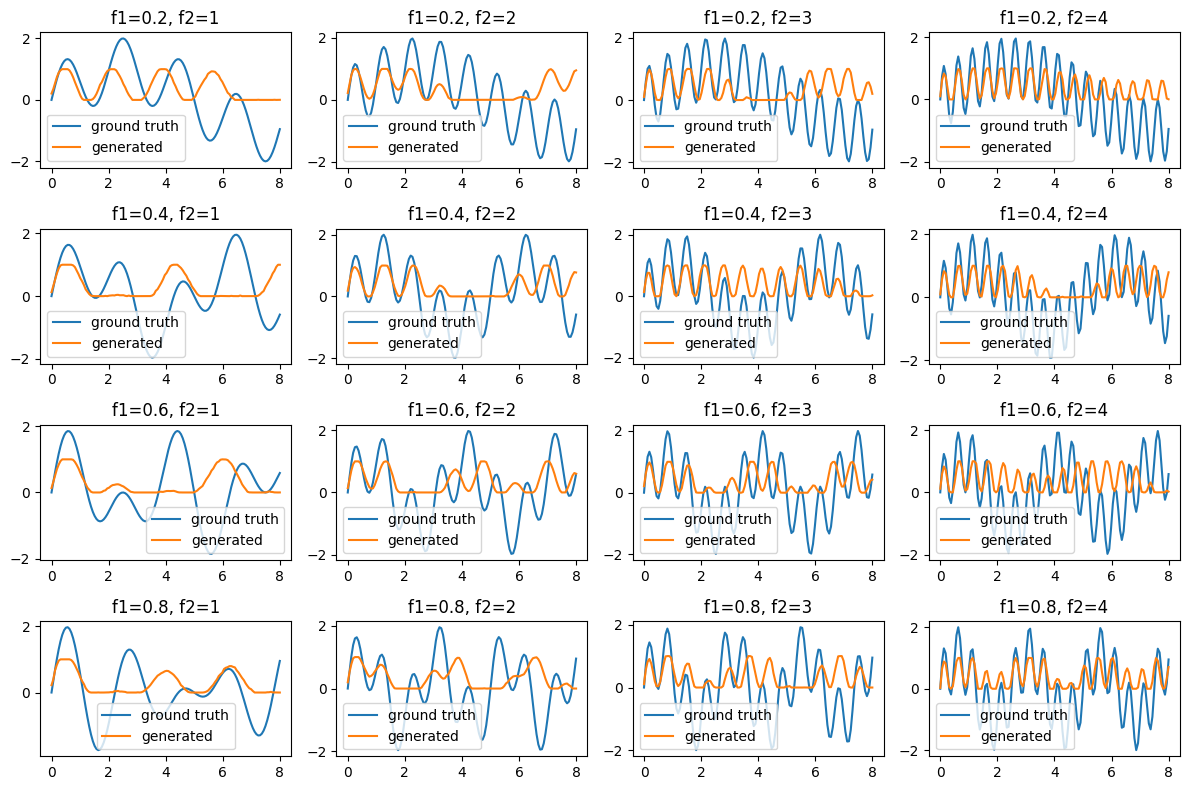

In [10]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(12, 8))
axess = axes.flatten()
for i in range(16):
    ground_truth = sinu_frequency(x_values, sampled_labels[i][0]) + sinu_frequency(x_values, sampled_labels[i][1])
    axess[i].plot(x_values, unnormalize_to_zero_to_one(normalize_to_neg_one_to_one(ground_truth)), label='ground truth')
    axess[i].plot(x_values, samples_numpy[i], label='generated')
    axess[i].set_title(f'f1={sampled_labels[i][0]}, f2={sampled_labels[i][1]}')
    # axes[i, j].set_title(f'f1={i+1}, f2={j+1}')
    axess[i].legend()
plt.tight_layout()
plt.show()

# get the samples for each milestone

In [4]:
milestone = 10
with open(f'./results/3_3_sine/sample-{milestone}.png', 'rb') as f:
    all_samples = pickle.load(f)
with open(f'./results/3_3_sine/loss_history.pkl', 'rb') as f:
    loss_history = pickle.load(f)
samples = all_samples.squeeze(1)

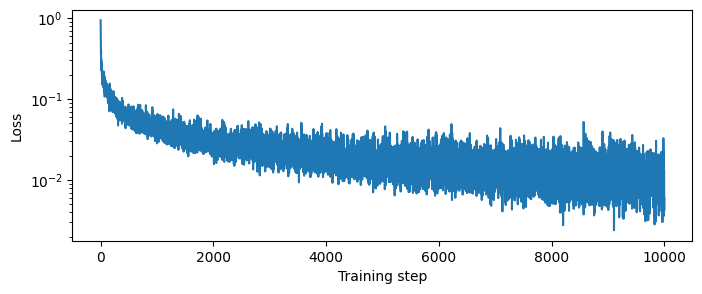

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(loss_history)
ax.axhline(0, ls='--', c='r', lw=1)
ax.set_yscale('log')
ax.set_xlabel('Training step')
ax.set_ylabel('Loss')
plt.show()

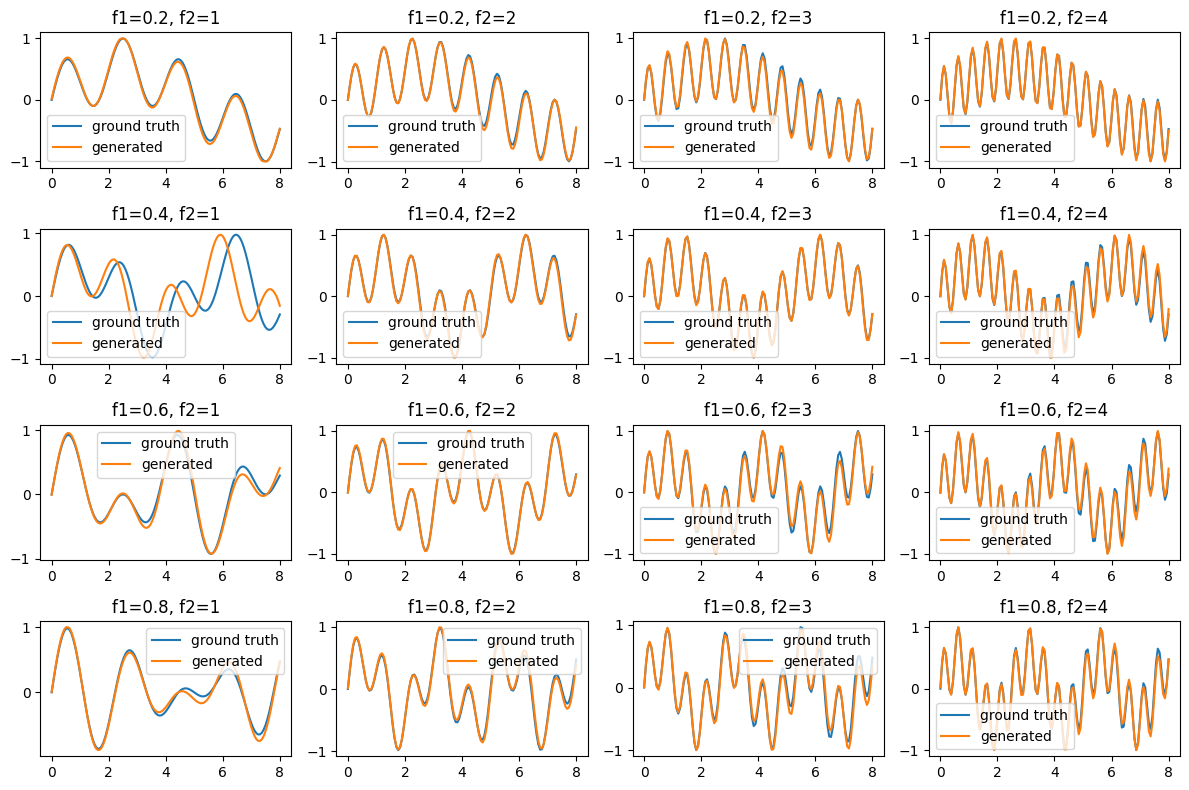

In [7]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(12, 8))
axess = axes.flatten()
for i in range(16):
    ground_truth = 0.5*(sinu_frequency(x_values, sampled_labels[i][0]) + sinu_frequency(x_values, sampled_labels[i][1]))
    axess[i].plot(x_values, ground_truth, label='ground truth')
    axess[i].plot(x_values, samples[i], label='generated')
    axess[i].set_title(f'f1={sampled_labels[i][0]}, f2={sampled_labels[i][1]}')
    # axes[i, j].set_title(f'f1={i+1}, f2={j+1}')
    axess[i].legend()
plt.tight_layout()
plt.show()

In [8]:
i = -1
ground_truth = 0.5*(sinu_frequency(x_values, sampled_labels[i][0]) + sinu_frequency(x_values, sampled_labels[i][1]))
frequency_domain_signal = np.fft.fft(samples[i])
frequency_domain_ground_truth = np.fft.fft(ground_truth)

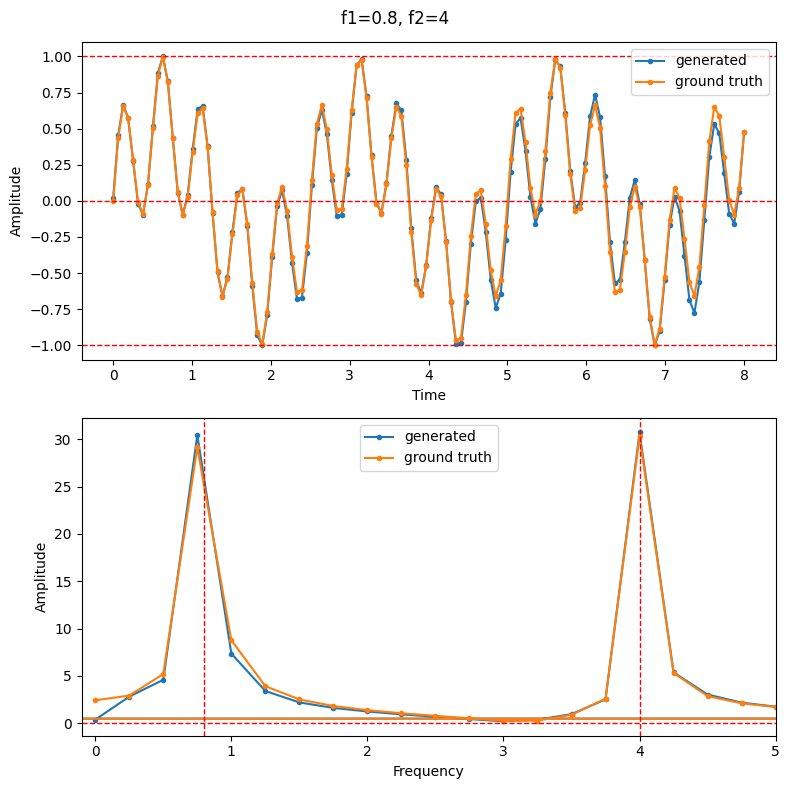

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].plot(x_values, samples[i], '.-', label='generated')
axs[0].plot(x_values, ground_truth, '.-', label='ground truth')
freq = np.fft.fftfreq(x_values.shape[-1], d=8/128/2)
axs[1].plot(freq, np.abs(frequency_domain_signal), '.-', label='generated')
axs[1].plot(freq, np.abs(frequency_domain_ground_truth), '.-', label='ground truth')
axs[0].axhline(0, ls='--', c='r', lw=1)
axs[0].axhline(1, ls='--', c='r', lw=1)
axs[0].axhline(-1, ls='--', c='r', lw=1)
axs[1].axhline(0, ls='--', c='r', lw=1)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Amplitude')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Amplitude')
axs[0].legend()
axs[1].legend()
axs[1].set_xlim(-0.1,5)
axs[1].axvline(sampled_labels[i][0], ls='--', c='r', lw=1)
axs[1].axvline(sampled_labels[i][1], ls='--', c='r', lw=1)

plt.suptitle(f'f1={sampled_labels[i][0]}, f2={sampled_labels[i][1]}')
plt.tight_layout()
plt.show()

# define the accuracy metrics in the time and the frequency domain

In [45]:
import numpy as np
from scipy.signal import find_peaks

def find_peak_indices(signal):
    peaks, _ = find_peaks(signal, height=10)
    return peaks

In [50]:
def time_domain_distance_measure(pred, gt):
    return np.sum(np.abs(pred - gt))

def frequency_domain_distance_measure(pred, gt):
    frequency_domain_pred = np.fft.fft(pred)
    frequency_domain_gt = np.fft.fft(gt)
    return np.sum(np.abs(np.abs(frequency_domain_pred) - np.abs(frequency_domain_gt)))

def frequency_domain_accuracy_measure(time, pred, gt):
    d = (np.max(time)-np.min(time))/len(time)/2
    freq = np.fft.fftfreq(len(time), d=d)
    frequency_domain_pred = np.fft.fft(pred)
    frequency_domain_gt = np.fft.fft(gt)
    
    signal_length = 20
    peaks_indices_pred = find_peak_indices(np.abs(frequency_domain_pred)[:signal_length])
    peaks_indices_gt = find_peak_indices(np.abs(frequency_domain_gt)[:signal_length])

    peaks_freqs_pred = freq[peaks_indices_pred]
    peaks_freqs_gt = freq[peaks_indices_gt]

    if len(peaks_freqs_pred) == 0:
        return 0, [0]
    else:
        assert len(peaks_freqs_gt)<=2, f"Found more than 2 peaks in the frequency domain ground truth: {len(peaks_freqs_gt)}."
        frequency_resolution = freq[1] - freq[0]

        accuracies = []
        for i in range(len(peaks_freqs_gt)):
            for j in range(len(peaks_freqs_pred)):
                if np.abs(peaks_freqs_pred[j] - peaks_freqs_gt[i]) < frequency_resolution:
                    accuracies.append(1)
                    break
                elif j == len(peaks_freqs_pred) - 1:
                    accuracies.append(0)
        
        if np.all(accuracies):
            overall_accuracy = 1
        else:
            overall_accuracy = 0
        
        return overall_accuracy, accuracies


### benchmark the accuracy measures

In [82]:
i = -1

gt = 0.5*(sinu_frequency(x_values, sampled_labels[i][0]) + sinu_frequency(x_values, sampled_labels[i][1]))
pred = samples[i].numpy()

In [87]:
time_diff = time_domain_distance_measure(gt, gt)
freq_diff = frequency_domain_distance_measure(gt, gt)
overall_accuracy, accuracies = frequency_domain_accuracy_measure(x_values, gt, gt)

In [88]:
time_diff

0.0

In [89]:
freq_diff

0.0

In [90]:
overall_accuracy

1

In [55]:
time = x_values

In [104]:
d = (np.max(time)-np.min(time))/len(time)/2
freq = np.fft.fftfreq(len(time), d=d)
frequency_domain_pred = np.fft.fft(pred)
frequency_domain_gt = np.fft.fft(gt)

signal_length = 20
peaks_indices_pred = find_peak_indices(np.abs(frequency_domain_pred)[:signal_length])
peaks_indices_gt = find_peak_indices(np.abs(frequency_domain_gt)[:signal_length])

peaks_freqs_pred = freq[peaks_indices_pred]
peaks_freqs_gt = freq[peaks_indices_gt]


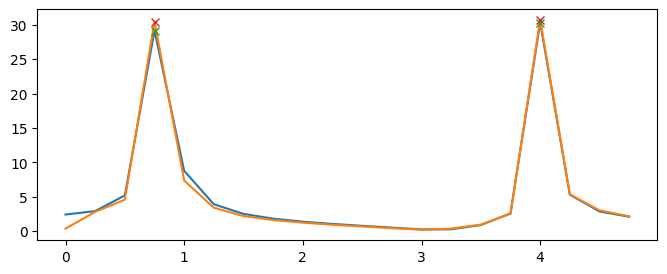

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(freq[:signal_length], np.abs(frequency_domain_gt)[:signal_length])
ax.plot(freq[:signal_length], np.abs(frequency_domain_pred)[:signal_length])

ax.plot(freq[peaks_indices_gt], np.abs(frequency_domain_gt)[peaks_indices_gt], "x")
ax.plot(freq[peaks_indices_pred], np.abs(frequency_domain_pred)[peaks_indices_pred], "x")

plt.show()

In [106]:
peaks_indices_pred

array([ 3, 16])

In [107]:
peaks_indices_gt

array([ 3, 16])

In [51]:
for i in range(16):
    gt = 0.5*(sinu_frequency(x_values, sampled_labels[i][0]) + sinu_frequency(x_values, sampled_labels[i][1]))
    pred = samples[i].numpy()

    time_diff = time_domain_distance_measure(pred, gt)
    freq_diff = frequency_domain_distance_measure(pred, gt)
    overall_accuracy, accuracies = frequency_domain_accuracy_measure(x_values, pred, gt)

    print(f"Sample {i}")
    print(f"Time domain distance measure: {time_diff}")
    print(f"Frequency domain distance measure: {freq_diff}")
    print(f"Overall accuracy: {overall_accuracy}")
    print(f"Accuracies: {accuracies}")
    print("--------------------------------------------")

Sample 0
Time domain distance measure: 69.44386331907901
Frequency domain distance measure: 235.616138112351
Overall accuracy: 0
Accuracies: [0, 1]
--------------------------------------------
Sample 1
Time domain distance measure: 56.92919359317015
Frequency domain distance measure: 230.93847472336955
Overall accuracy: 0
Accuracies: [0, 1]
--------------------------------------------
Sample 2
Time domain distance measure: 61.448660738693476
Frequency domain distance measure: 157.2965758169312
Overall accuracy: 0
Accuracies: [1, 0]
--------------------------------------------
Sample 3
Time domain distance measure: 69.98178631732952
Frequency domain distance measure: 252.63503012357327
Overall accuracy: 0
Accuracies: [0, 0]
--------------------------------------------
Sample 4
Time domain distance measure: 77.91324940695284
Frequency domain distance measure: 226.39242093417045
Overall accuracy: 0
Accuracies: [1, 0]
--------------------------------------------
Sample 5
Time domain distan

# Metric visualization

In [10]:
milestone = 1
with open(f'./results/3_3_sine/sample-{milestone}.png', 'rb') as f:
    all_samples = pickle.load(f)
with open(f'./results/3_3_sine/loss_history.pkl', 'rb') as f:
    loss_history = pickle.load(f)
samples = all_samples.squeeze(1)

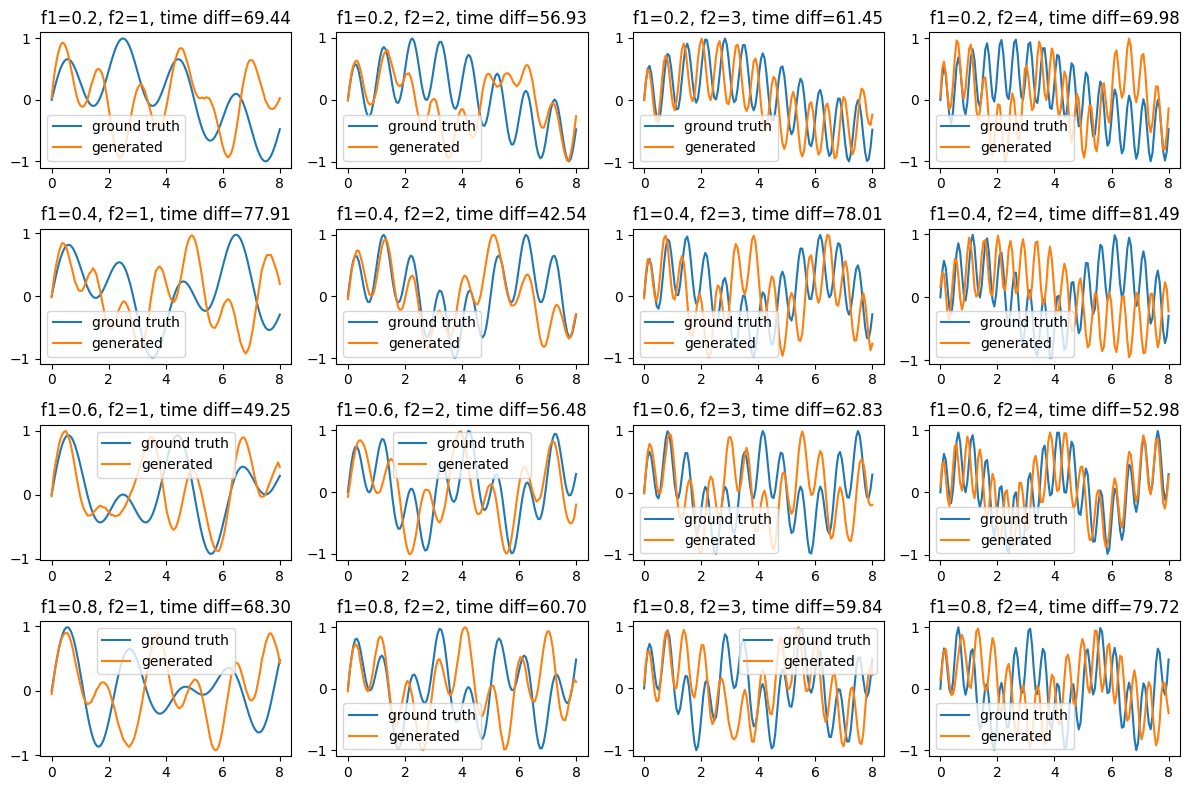

In [11]:
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
axess = axes.flatten()
for i in range(16):
    gt = 0.5*(sinu_frequency(x_values, sampled_labels[i][0]) + sinu_frequency(x_values, sampled_labels[i][1]))
    pred = samples[i].numpy()
    time_diff = time_domain_distance_measure(pred, gt)
    axess[i].plot(x_values, gt, label='ground truth')
    axess[i].plot(x_values, pred, label='generated')
    axess[i].set_title(f'f1={sampled_labels[i][0]}, f2={sampled_labels[i][1]}, time diff={time_diff:.2f}')
    # axes[i, j].set_title(f'f1={i+1}, f2={j+1}')
    axess[i].legend()
plt.tight_layout()
plt.show()

In [36]:
milestone = 1
with open(f'./results/3_3_sine/sample-{milestone}.png', 'rb') as f:
    all_samples = pickle.load(f)
with open(f'./results/3_3_sine/loss_history.pkl', 'rb') as f:
    loss_history = pickle.load(f)
samples = all_samples.squeeze(1)

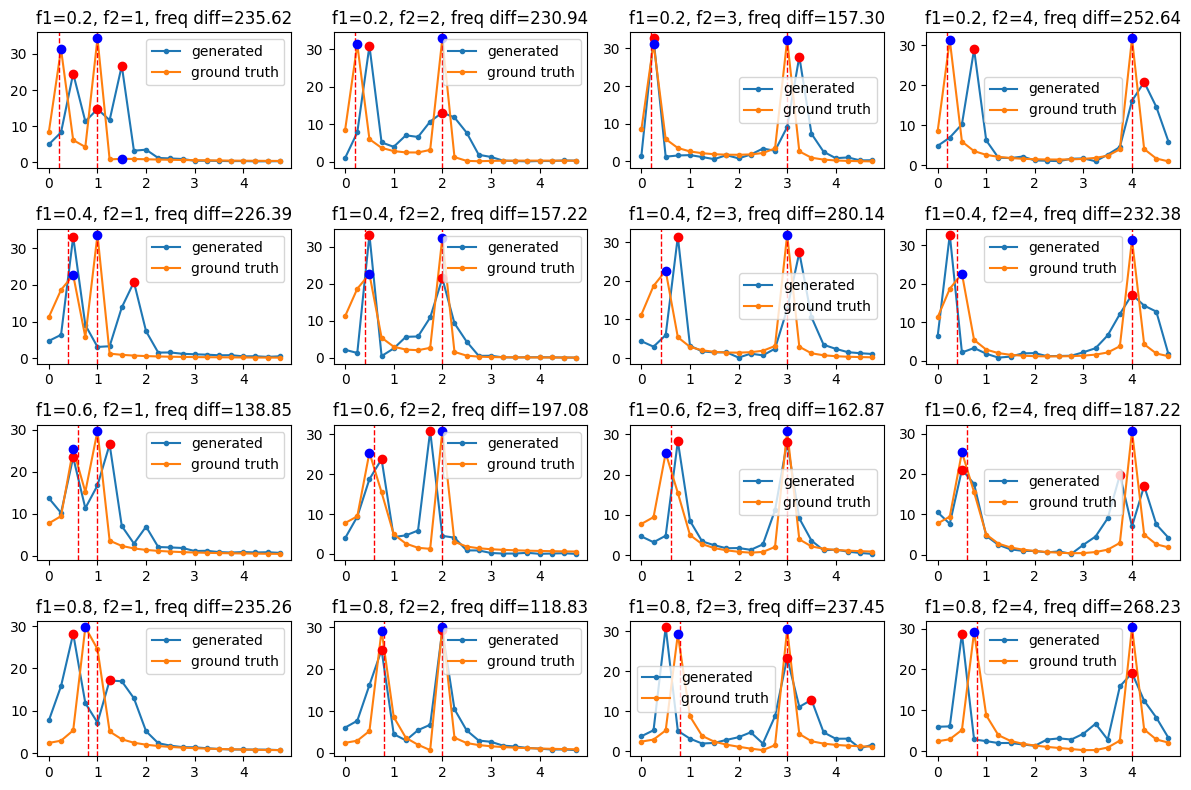

In [44]:
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
axess = axes.flatten()
for i in range(16):
    gt = 0.5*(sinu_frequency(x_values, sampled_labels[i][0]) + sinu_frequency(x_values, sampled_labels[i][1]))
    pred = samples[i].numpy()
    frequency_domain_signal = np.fft.fft(pred)
    frequency_domain_ground_truth = np.fft.fft(gt)
    freq = np.fft.fftfreq(x_values.shape[-1], d=8/128/2)
    freq_diff = frequency_domain_distance_measure(pred, gt)

    axess[i].plot(freq[:20], np.abs(frequency_domain_signal)[:20], '.-', label='generated')
    axess[i].plot(freq[:20], np.abs(frequency_domain_ground_truth)[:20], '.-', label='ground truth')
    axess[i].set_title(f'f1={sampled_labels[i][0]}, f2={sampled_labels[i][1]}, freq diff={freq_diff:.2f}')
    axess[i].axvline(sampled_labels[i][0], ls='--', c='r', lw=1)
    axess[i].axvline(sampled_labels[i][1], ls='--', c='r', lw=1)
    # peaks_indices = find_peak_indices(frequency_domain_signal[:20])
    peaks_indices, _ = find_peaks(np.abs(frequency_domain_signal)[:20], height=10)
    axess[i].plot(freq[:20][peaks_indices], np.abs(frequency_domain_signal)[:20][peaks_indices], "ro")
    peaks_indices_gt, _ = find_peaks(np.abs(frequency_domain_ground_truth)[:20], height=1)
    axess[i].plot(freq[:20][peaks_indices_gt], np.abs(frequency_domain_ground_truth)[:20][peaks_indices_gt], "bo")
    # axes[i, j].set_title(f'f1={i+1}, f2={j+1}')
    axess[i].legend()
plt.tight_layout()
plt.show()

### Testing peak finding
signal aliasing, need to have more fine-grained data to be able to reliably parse through the peak

In [30]:
pred = samples[0].numpy()
frequency_domain_signal = np.fft.fft(pred)
frequency_domain_ground_truth = np.fft.fft(gt)
freq = np.fft.fftfreq(x_values.shape[-1], d=8/128/2)
freq = freq[:20]
freq_sig = np.abs(frequency_domain_signal)[:20]

In [32]:
peaks_indices, _ = find_peaks(freq_sig)

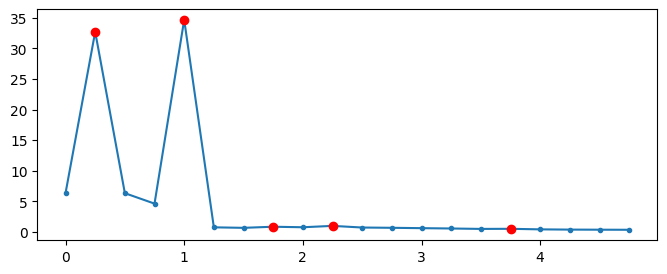

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(freq, freq_sig, '.-', label='generated')
ax.plot(freq[peaks_indices], freq_sig[peaks_indices], "ro")
plt.show()

# Plot the metrics evolution over training

In [53]:
time_diff_arr = []
freq_diff_arr = []
overall_acc_arr = []
low_acc_arr = []
high_acc_arr = []


for milestone in range(1,11):
    with open(f'./results/3_3_sine/sample-{milestone}.png', 'rb') as f:
        all_samples = pickle.load(f)
    with open(f'./results/3_3_sine/loss_history.pkl', 'rb') as f:
        loss_history = pickle.load(f)
    samples = all_samples.squeeze(1)
    time_diffs = []
    freq_diffs = []
    overall_accs = []
    low_accs = []
    high_accs = []
    for i in range(16):
        gt = 0.5*(sinu_frequency(x_values, sampled_labels[i][0]) + sinu_frequency(x_values, sampled_labels[i][1]))
        pred = samples[i].numpy()
        time_diff = time_domain_distance_measure(pred, gt)
        time_diffs.append(time_diff)
        frequency_domain_signal = np.fft.fft(pred)
        frequency_domain_ground_truth = np.fft.fft(gt)
        freq = np.fft.fftfreq(x_values.shape[-1], d=8/128/2)
        freq_diff = frequency_domain_distance_measure(pred, gt)
        overall_accuracy, accuracies = frequency_domain_accuracy_measure(x_values, pred, gt)

        freq_diffs.append(freq_diff)
        overall_accs.append(overall_accuracy)
        if len(accuracies) < 2:
            low_accs.append(accuracies[0])
            high_accs.append(accuracies[0])
        else:
            low_accs.append(accuracies[0])
            high_accs.append(accuracies[1])

    time_diff_arr.append(time_diffs)
    freq_diff_arr.append(freq_diffs)
    overall_acc_arr.append(overall_accs)
    low_acc_arr.append(low_accs)
    high_acc_arr.append(high_accs)

In [54]:
time_diff_arr = np.array(time_diff_arr)
freq_diff_arr = np.array(freq_diff_arr)
overall_acc_arr = np.array(overall_acc_arr)
low_acc_arr = np.array(low_acc_arr)
high_acc_arr = np.array(high_acc_arr)

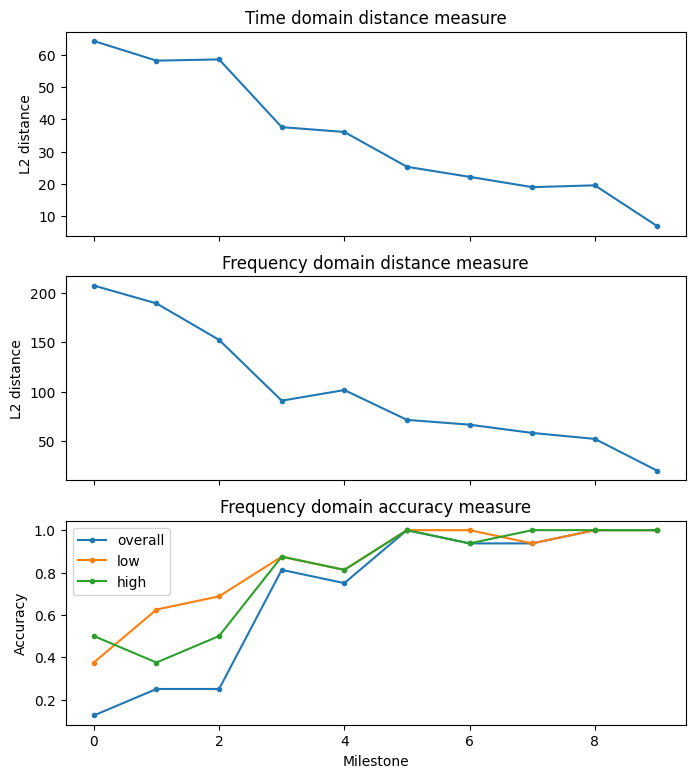

In [61]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 9))
axs[0].plot(np.mean(time_diff_arr, axis=1), '.-', label='time domain')
axs[0].set_ylabel('L2 distance')
axs[0].set_title('Time domain distance measure')
axs[1].plot(np.mean(freq_diff_arr, axis=1), '.-', label='frequency domain')
axs[1].set_ylabel('L2 distance')
axs[1].set_title('Frequency domain distance measure')
axs[2].plot(np.mean(overall_acc_arr, axis=1), '.-', label='overall')
axs[2].plot(np.mean(low_acc_arr, axis=1), '.-', label='low')
axs[2].plot(np.mean(high_acc_arr, axis=1), '.-', label='high')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Frequency domain accuracy measure')
axs[2].set_xlabel('Milestone')
axs[2].legend()
plt.show()